###  Created by Luis A. Sanchez-Perez (alejand@umich.edu).
<p><span style="color:green"><b>Copyright &#169;</b> Do not distribute or use without authorization from author.</span></p>

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs

In [2]:
def plot_boundary(mdl,X,y,mesh,threshold):
    # boundary and regions
    plt.scatter(X[:,0],X[:,1],c=y,edgecolor='k',s=50)
    prob = mdl.predict_proba(mesh)[:,1]
    pts = int(np.sqrt(mesh.shape[0]))
    x1 = mesh[:,0].reshape((pts,pts))
    x2 = mesh[:,1].reshape((pts,pts))
    z = prob.reshape((pts,pts))
    plt.contour(x1, x2, z, levels = [threshold], colors = 'black')
    plt.contourf(x1, x2, z >= threshold, alpha = 0.10)
    
def compute_metrics(mdl,X,y):
    # trainig metrics
    y_pred = mdl.predict(X)
    print('Training Metrics:')
    print('Accuracy: ', '%.2f'  % accuracy_score(y, y_pred))
    print('F1 Score: ', '%.2f'  % f1_score(y, y_pred))
    print('Recall: ', '%.2f'  % recall_score(y, y_pred))
    print('Precision: ', '%.2f'  % precision_score(y, y_pred))
    
def build_dataset1():
    pts = 100
    sep = 3;
    cov = np.array([[1, 0.1],[0.1, 1]])
    mean = sep * np.array([-1,1])
    left_top = rnd.multivariate_normal(mean,cov,pts)
    mean = sep * np.array([1,1])
    right_top = rnd.multivariate_normal(mean,cov,pts)
    mean = sep * np.array([1,-1])
    right_bot = rnd.multivariate_normal(mean,cov,pts)
    mean = sep * np.array([-1,-1])
    left_bot = rnd.multivariate_normal(mean,cov,pts)
    X = np.concatenate((left_top,right_bot,right_top,left_bot))
    y = np.concatenate((np.ones(2*pts), np.zeros(2*pts)))
    # Builds mesh
    bottom = np.min(X,0)
    top = np.max(X,0)
    pts = 200
    mx = np.linspace(bottom[0], top[0], pts)  # x1
    my = np.linspace(bottom[1], top[1], pts)  # x2
    mx, my = np.meshgrid(mx, my)
    mesh = np.vstack((mx.flatten(), my.flatten())).T
    # Normalize both dataset and mesh
    sc = StandardScaler()
    sc.fit(X)
    X = sc.transform(X)
    mesh = sc.transform(mesh)
    return X,y,mesh

def build_dataset2():
    X,y = make_circles(noise=0.2, factor=0.5, random_state=1,n_samples=300)
    # Builds mesh
    bottom = np.min(X,0)
    top = np.max(X,0)
    pts = 200
    mx = np.linspace(bottom[0], top[0], pts)  # x1
    my = np.linspace(bottom[1], top[1], pts)  # x2
    mx, my = np.meshgrid(mx, my)
    mesh = np.vstack((mx.flatten(), my.flatten())).T
    # Normalize both dataset and mesh
    sc = StandardScaler()
    sc.fit(X)
    X = sc.transform(X)
    mesh = sc.transform(mesh)
    return X,y,mesh
    
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

## Motivation
#### But, why do we need another algorithm when we have Logistic Regression?
Consider a supervised learning classification problem where you have a training set like the ones shown below:

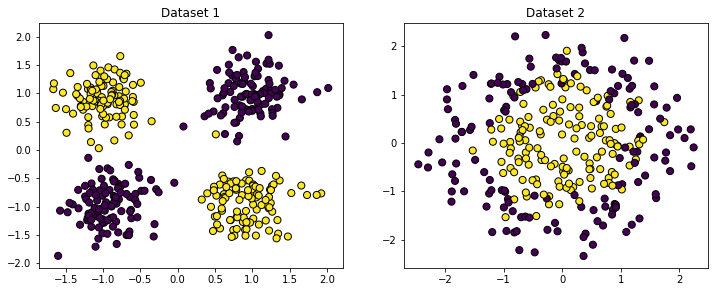

In [3]:
rnd.seed(1)
X1,y1,mesh1 = build_dataset1()
X2,y2,mesh2 = build_dataset2()
plt.figure(figsize=(12,4.5))
plt.subplot(121)
plt.scatter(X1[:,0],X1[:,1],c=y1,s=50,edgecolor='k')
plt.title('Dataset 1')
plt.subplot(122)
plt.title('Dataset 2')
plt.scatter(X2[:,0],X2[:,1],c=y2,s=50,edgecolor='k')

#### Then...
If you want to apply logistic regression to this problem, one thing you could do is apply logistic regression with a lot of nonlinear features. This particular method works well when you have only, say, two features: x1 and x2. But for many interesting machine learning problems would have a lot more features than just two, and <b>determining what polynomial terms to include is not trivial</b>.

## Neural Networks
What is a neural network? Collection of connected artificial neurons.
<b>The simplest type of artificial neuron is called the perceptron</b>. Perceptrons were developed in the 1950s and 1960s by the scientist Frank Rosenblatt, inspired by earlier work by Warren McCulloch and Walter Pitts. Today, it's more common to use other models of artificial neurons.

### Perceptron - Neuron with step activation function

A perceptron takes several binary inputs, \\( x_1, x_2, \ldots \\) and produces a single binary output:

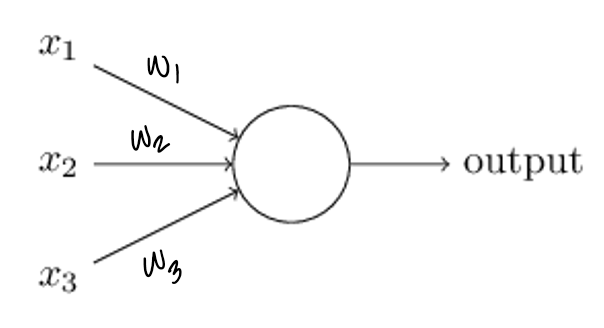</img>

Real values named <b>weights \\(w_1,w_2,\ldots\\)</b> are introduced as a form of expressing the importance of the respective inputs to the output. To put it in more precise algebraic terms:

\begin{eqnarray}
  \mbox{output} & = & \left\{ \begin{array}{ll}
      0 & \mbox{if } \sum_j w_j x_j \leq \mbox{ threshold} \\
      1 & \mbox{if } \sum_j w_j x_j > \mbox{ threshold}
      \end{array} \right.
\tag{1}\end{eqnarray}

Using the bias instead of the threshold and a dot product instead of summation, the perceptron rule can be rewritten:

\begin{eqnarray}
  \mbox{output} = \mbox{step}(w\cdot x + b) \left\{ 
    \begin{array}{ll} 
      0 & \mbox{if } w\cdot x + b \leq 0 \\
      1 & \mbox{if } w\cdot x + b > 0
    \end{array}
  \right.
\tag{2}\end{eqnarray}

As you can infer from the equations, <b>the smaller the bias the easier is to get zero as the output</b> (it represents how biased is our model to say is class one without even looking at the features).

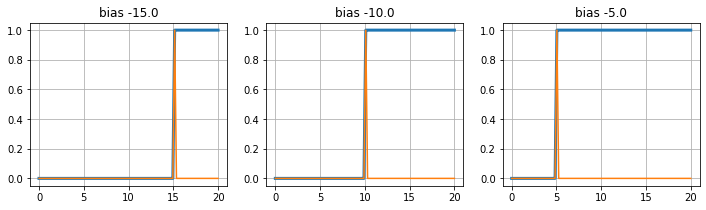

In [4]:
# Simulation of the perceptron output
options = [-15, -10, -5]
wx = np.linspace(0,20,100)
fig = plt.figure(figsize=(12,3))
for i,b in enumerate(options):
    output = wx + b > 0
    plt.subplot(1,len(options),i+1)
    plt.plot(wx,output,linewidth=3)
    derivative = np.concatenate(([0], np.diff(output)))
    plt.plot(wx,derivative)
    plt.grid()
    plt.title('bias %.1lf' % b)

### Perceptron learning rule
Updating weight vector by adding/substracting incorrectly classified inputs

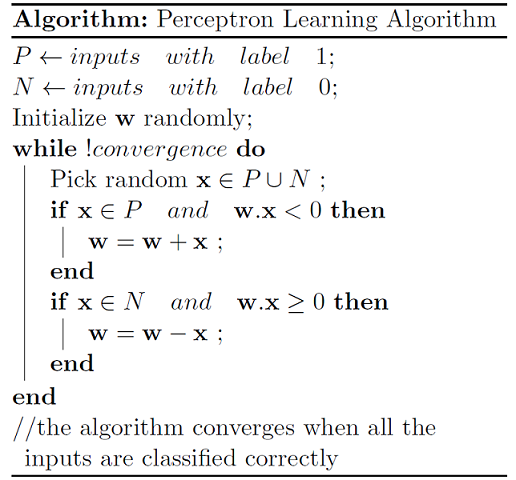

### Multilayer Perceptron (MLP) - Vanilla NN
Its just a collection connected perceptrons

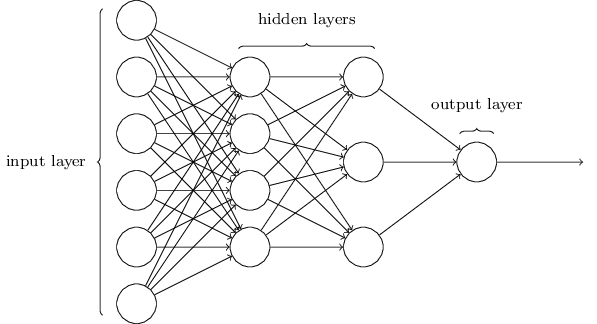

Network's arquitecture as the one shown above are also called <b>feedforward neural networks</b>. This means there are no loops in the network - information is always fed forward, never fed back.

While the design of the input and output layers of a neural network is often straightforward, there can be quite an art to the design of the hidden layers. There are many design heuristics for the hidden layers, which help people get the behaviour they want out of their nets.

### Sigmoid Neuron - Neuron with a sigmoid activation function

Suppose we make a small change in some weight (or bias). What we'd like is for this small change in weight to cause only a small corresponding change in the output from the network. The problem is that this isn't what happens when our network contains perceptrons. 

In fact, <b>a small change in the weights or bias of any single perceptron</b> in the network can sometimes cause the output of that perceptron to completely flip, say from 0 to 1. That flip <b>may then cause the behaviour of the rest of the network to completely change in some very complicated way</b>.

We can overcome this problem by introducing a new type of artificial neuron called a <b>sigmoid neuron</b>. Sigmoid neurons are similar to perceptrons, but modified so that small changes in their weights and bias cause only a small change in their output.

The output of the sigmoid neuron could be represented as:

\begin{eqnarray} 
    \mbox{output} & = & \sigma(w\cdot x + b) & = & \frac{1}{1+\exp(-\sum_j w_j x_j-b)}
\tag{3}\end{eqnarray}

And its derivative with respect to \\(z\\) is defined as:

\begin{eqnarray} 
    \frac{d\sigma}{dz} & = & \sigma(z) (1 - \sigma(z))
\tag{4}\end{eqnarray}

So its derivative with respect to \\(w\\) and \\(b\\) is defined as:

\begin{eqnarray} 
    \frac{d\sigma}{dw} & = & \sigma(z) (1 - \sigma(z))\cdot x\\
\tag{5}\end{eqnarray}

\begin{eqnarray} 
    \frac{d\sigma}{db} & = & \sigma(z) (1 - \sigma(z))\cdot 1\\
\tag{6}\end{eqnarray}

\begin{eqnarray} 
    \mbox{where } & z & = w\cdot x + b
\end{eqnarray}
    
    


For historical reasons, <b>such multiple layer networks are still called multilayer perceptrons or MLPs, even when they are made up of sigmoid neurons, not perceptrons</b>.

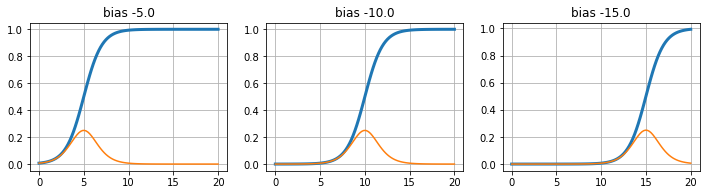

In [5]:
# Simulation of the sigmoid neuron output
options = [-5, -10, -15]
wx = np.linspace(0,20,100)
fig = plt.figure(figsize=(12,6))
for i,b in enumerate(options):
    z = wx + b
    output = sigmoid(z)
    plt.subplot(2,len(options),i+1)
    plt.plot(wx,output, linewidth=3)
    derivative = sigmoid(z)*(1 - sigmoid(z))
    plt.plot(wx,derivative)
    plt.grid()
    plt.title('bias %.1lf' % b)

### How neural networks can learn complex features?

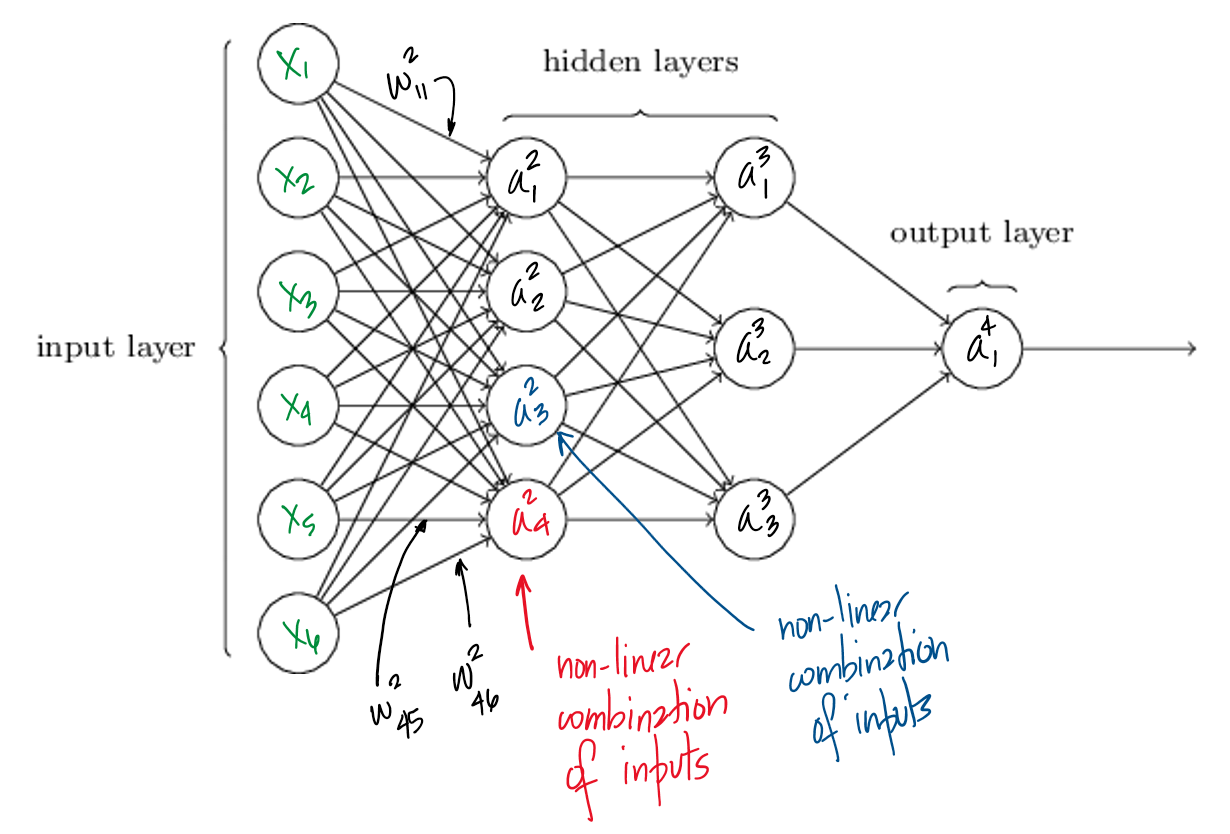

Let's begin with a notation which lets us refer to weights in the network in an unambiguous way. We'll use \\(w^l_{jk}\\) to denote the weight for the connection from the \\(k^{\rm th}\\) neuron in the \\((l-1)^{\rm th}\\) layer to the \\(j^{th}\\) neuron in the lth layer.

We use a similar notation for the network's biases and activations. Explicitly, we use \\(b^l_j\\) for the bias of the \\(j^{\rm th}\\) neuron in the \\(l^{\rm th}\\) layer. And we use \\(a^l_j\\) for the activation of the \\(j^{\rm th}\\) neuron in the \\(l^{\rm th}\\) layer.

<b>As you can see all neurons outputs from the hidden layers are complex non-linear combinations of the original inputs, and the network throughtout the selection of the weight can learn complex non-linear combinations of the inputs to explain the outputs based on the minimization of the cost function.</b>

### So lets train a MLP to solve the problems from the datasets before

Training Metrics:
Accuracy:  1.00
F1 Score:  1.00
Recall:  1.00
Precision:  1.00
Iterations: 46


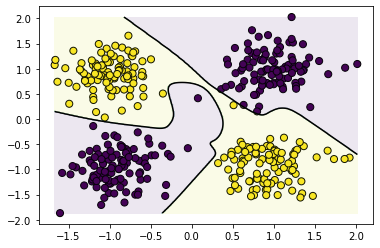

In [6]:
regularization = 1e-4
threshold = 0.5
mdl = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10,6),activation='logistic',
                    alpha=regularization,max_iter=1000, early_stopping=False,
                    validation_fraction=0.1,verbose=True)
mdl.fit(X1,y1)
plot_boundary(mdl,X1,y1,mesh1,threshold)
compute_metrics(mdl,X1,y1)
print('Iterations:',mdl.n_iter_)

Training Metrics:
Accuracy:  0.90
F1 Score:  0.90
Recall:  0.89
Precision:  0.91
Iterations: 423


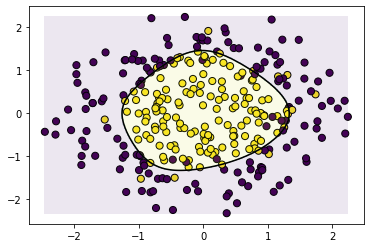

In [7]:
regularization = 0
threshold = 0.5
mdl = MLPClassifier(solver='adam', hidden_layer_sizes=(3),activation='logistic',
                    alpha=regularization,max_iter=1000, early_stopping=False,
                    validation_fraction=0.1, verbose=True)
mdl.fit(X2,y2)
plot_boundary(mdl,X2,y2,mesh2,threshold)
compute_metrics(mdl,X2,y2)
print('Iterations:',mdl.n_iter_)

### Feedfoward in action
Lets try to manually compute the feedfoward pass of the last network obtained after training for a given input and compare to the function call mdl.predict_proba()

2 - 3 - 1

In [8]:
mdl.coefs_[0]

array([[ 1.12146542,  4.14318854, -0.06334689],
       [ 1.34721793, -0.95612502,  2.34525823]])

In [9]:
mdl.intercepts_

[array([-0.75553825,  4.09899977,  1.81161947]), array([-24.62405058])]

In [10]:
inp = np.array([1,0.5]).reshape(1,2)
inp

array([[1. , 0.5]])

In [11]:
a = inp
for i in range(len(mdl.coefs_)):
    z = np.dot(a,mdl.coefs_[i]) + mdl.intercepts_[i]
    a = sigmoid(z)
print(a)

[[0.71156176]]


In [12]:
mdl.predict_proba(inp)

array([[0.28843824, 0.71156176]])